In [27]:
import math
import re
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import spacy
import matplotlib.pyplot as plt
from scipy.stats import linregress
nlp = spacy.load("en_core_web_lg")

OUTPUT_DIR="data"
SCHOOL="boston"
SUBJECT="opinions"
START_YEAR=2010
FINAL_YEAR=2022

In [28]:
def getCovDispersion(wv):
    N = len(wv)
    cov = np.cov(wv)
    return (N,
            np.trace(cov)/N,
            np.linalg.norm(cov, ord=1)/N,
            np.linalg.norm(cov, ord=2)/N,
            np.linalg.norm(cov, ord=np.inf)/N,
            )

def cosine_distance(a, b):
    dot = np.dot(a, b)
    a_mag = np.linalg.norm(a)
    b_mag = np.linalg.norm(b)

    # Calculate and return the cosine distance
    return 1 - (dot / (a_mag * b_mag))

def getPairwiseDispersion(wv, measure):
    if len(wv) <= 1: return 0.0
    distance = 0.0
    vec = wv[0]
    for v in wv[1:]:
        distance += measure(vec, v)
    return distance + getPairwiseDispersion(wv[1:], measure)

def getNormalizedPairwiseDispersion(wv, measure):
    N = len(wv)
    return getPairwiseDispersion(wv, measure) / (N * (N-1)/2.)

diversity_words = ['diversity', 'equity','inclusion','inclusive','inclusivity','equality', 'equal opportunity','social justice','racial justice','multi-cultural','multicultural','intercultural','intersectional', 'intersectionality','anti-discrimination']
diversity_pattern = "\b" + "|".join(diversity_words) + "\b"

english_stopwords = stopwords.words('english')
def prepText(text_series):
    text_series = text_series.apply(
        lambda x: " ".join(lemmatizer.lemmatize(w.lower()) for w in x.split()
                           if w not in english_stopwords))
    total_diversity_words = sum([len(re.findall(diversity_pattern, text))
                                 for text in text_series])
    return text_series, total_diversity_words

In [29]:
results = []
for year in range(START_YEAR, FINAL_YEAR + 1):
    df = pd.read_parquet(f"{OUTPUT_DIR}/{SCHOOL}-{SUBJECT}-{year}.parquet")

    df['body_prepped'], num_diversity_words = prepText(df.body)
    wv = [nlp(s) for s in df['body_prepped']]
    docmatrix = np.array([v.vector for v in wv])

    cov = getCovDispersion(docmatrix)
    pairwise = getNormalizedPairwiseDispersion(docmatrix, cosine_distance)
    result = {'year': year,
              'pairwise': pairwise,
              'size': cov[0],
              'trace': cov[1],
              'norm-1': cov[2],
              'norm-2': cov[3],
              'norm-inf': cov[4],
              'diversity-words': num_diversity_words,
              'mentions-norm': num_diversity_words / cov[0]
              }
    results.append(result)
    print(f"{year}, {cov[0]}, {pairwise}")

results_df = pd.DataFrame.from_records(results)
results_df.set_index('year')



2010, 20, 0.10534260712171856
2011, 20, 0.061116586547148855
2012, 2, 0.09096038341522217
2013, 8, 0.07166267505713872
2014, 10, 0.06002822054757012
2015, 2, 0.055384933948516846
2016, 190, 0.09492018524234722
2017, 34, 0.1129846921897827
2018, 45, 0.07531339983747463
2019, 33, 0.08194887118809151
2020, 38, 0.09653648212658053
2021, 53, 0.0822388800982986
2022, 49, 0.08462038286486451


,pairwise,size,trace,norm-1,norm-2,norm-inf,diversity-words,mentions-norm
year,,,,,,,,
2010,0.105343,20,1.760412,1.764072,1.580146,1.764072,12,0.600000
2011,0.061117,20,1.556511,1.646709,1.465420,1.646709,2,0.100000
2012,0.090960,2,1.867139,1.825674,1.782345,1.825674,2,1.000000
2013,0.071663,8,1.685101,1.758891,1.588628,1.758891,0,0.000000
2014,0.060028,10,1.814150,1.845321,1.714578,1.845321,30,3.000000
2015,0.055385,2,1.821491,1.845561,1.771374,1.845561,5,2.500000
2016,0.094920,190,1.542945,1.636550,1.401238,1.636550,58,0.305263
2017,0.112985,34,1.759207,1.746517,1.578059,1.746517,6,0.176471
2018,0.075313,45,1.717822,1.782204,1.601589,1.782204,22,0.488889


mentions-norm slope:-0.06386, int:1.08044, r:-0.26119, p:0.38871, se:0.07116, x:range(0, 13)
pairwise slope:0.00067, int:0.07850, r:0.14851, p:0.62825, se:0.00135, x:range(0, 13)


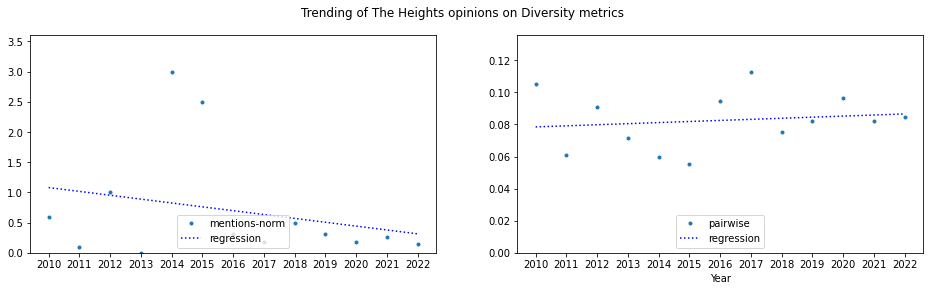

In [30]:
columns = ["mentions-norm", "pairwise"]

# Create a figure with subplots
fig, axs = plt.subplots(nrows=1, ncols=len(columns), sharex=True, figsize=(16, 4))

# Loop through the columns and plot each one
for ax, column in zip(axs, columns):
    # Select the data for the current column
    x = range(len(results_df.index))
    y = results_df[column]

    # Calculate the linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    print("{} slope:{:.5f}, int:{:.5f}, r:{:.5f}, p:{:.5f}, se:{:.5f}, x:{}".format(
        column, slope, intercept, r_value, p_value, std_err, x))

    # Plot the data and the linear regression line
    results_df[column].plot(ax=ax, style=".", x=x, y=y, label=column)
    ax.plot(x, intercept + slope * x, 'b:', label='regression')
    ax.set_ylim(0, max(y) * 1.2)

    # Add a legend
    ax.legend(loc='lower center')
    # Add x-label for the years
    ax.set_xticks(results_df.index)
    ax.set_xticklabels(results_df.year)

plt.xlabel("Year")
plt.suptitle("Trending of The Heights opinions on Diversity metrics")
plt.show()